## Inference on built models with nucleus7

To run this tutorial, first complete (or just run) build_and_train one

In this tutorial, you will learn how to use already trained models and make inference with them on new data

We will make some predictions on cifar10 dataset with already trained model and save input images with predicted class annotation in the name. We will use latest exported model for it.

In [1]:
import os
import pprint

import numpy as np
import skimage.io
import tensorflow as tf

import nucleus7 as nc7


cifar10 = tf.keras.datasets.cifar10
_, (x_test, y_test) = cifar10.load_data()

number_of_samples = globals().get('number_of_samples')
if number_of_samples:
    x_test = x_test[:number_of_samples]
    y_test = y_test[:number_of_samples]

project_dir = 'project_01_logs/nc7_sample_project'

cifar10_class_annotation = {cl: cl_name for cl, cl_name in
                            enumerate(["airplane", "automobile", "bird", "cat", "deer",
                                       "dog", "frog", "horse", "ship", "truck"])}

### 1. Define DataFeeder

In [2]:
class CifarDataFeeder(nc7.data.DataFeeder):
    generated_keys = ['image']

    def __init__(self, **kwargs):
        super(CifarDataFeeder, self).__init__(**kwargs)

    def build_generator(self):
        for x in x_test:
            yield {'image': x.astype(np.float32)/255}

### 2. Define Callbacks

In [3]:
class PrintCallback(nc7.coordinator.CoordinatorCallback):

    def __init__(self, **kwargs):
        super(PrintCallback, self).__init__(**kwargs)

    def on_iteration_end(self):
        iter_n = self.iteration_info.iteration_number
        time_exec = self.iteration_info.execution_time
        print('iter {:05d} | time_exec {:1.3f}'.format(iter_n, time_exec))


class ImageSaver(nc7.coordinator.CoordinatorCallback):
    incoming_keys = ['image', 'top_classes']

    def __init__(self, **kwargs):
        super(ImageSaver, self).__init__(**kwargs)
        self.class_annotations = cifar10_class_annotation

    def on_iteration_end(self, image, top_classes):
        iter_n = self.iteration_info.iteration_number
        log_dir = self.log_dir
        for i, (image_i, top_classes_i) in enumerate(zip(image, top_classes)):
            class_names = "-".join([self.class_annotations[each_class_id] for each_class_id in top_classes_i])
            save_fname = "image_{:03d}_{:03d}_predicted_{}.png".format(iter_n, i+1, class_names)
            save_fname = os.path.join(log_dir, save_fname)
            skimage.io.imsave(save_fname, image_i)

### 3. Build ModelHandler and Inferer

It is possible to build all of object explicitly (as in build_and_train example), but we will use builder functions from `nc7.builders` module.

Let's list the project directory:

In [4]:
def print_dir_content():
    for root, subdirs, files in sorted(os.walk(project_dir)):
        if root == project_dir:
            continue
        if not files and subdirs:
            continue
        print('{}: \n\t\t{}'.format(root, files))

### 4. Run inference

In [5]:
batch_size = 100
datafeeder_config = {'class_name': 'CifarDataFeeder'}
callbacks_config = [
    {
        'class_name': 'PrintCallback',
        'name': 'log_callback',
        'inbound_nodes': []
    },
    {
        'class_name': 'ImageSaver',
        'name': 'image_saver',
        'inbound_nodes': ['dataset', 'classes_pp'],
        'incoming_keys_mapping': {
            'classes_pp': {
                'classes': '_',
                'top_scores': '_'
            }
        }
    },
]
# we would like to output 2 top_k class predictions
# here it is shown mostly for teaching reasons how to change the model
# parameter during inference
inferer_config = {
    "model_parameters": {"classes_pp": {"top_k": 2}}
}
inferer = nc7.build_infer(project_dir=project_dir,
                          batch_size=batch_size,
                          datafeeder_config=datafeeder_config,
                          callbacks_config=callbacks_config,
                          inferer_config=inferer_config)

Instructions for updating:
This function will only be available through the v1 compatibility library as tf.compat.v1.saved_model.loader.load or tf.compat.v1.saved_model.load. There will be a new function for importing SavedModels in Tensorflow 2.0.
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from project_01_logs/nc7_sample_project/saved_models/1558359202/variables/variables


Lets draw the project DNA:

/home/alexv/anaconda3/lib/python3.5/site-packages/matplotlib/figure.py:457: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


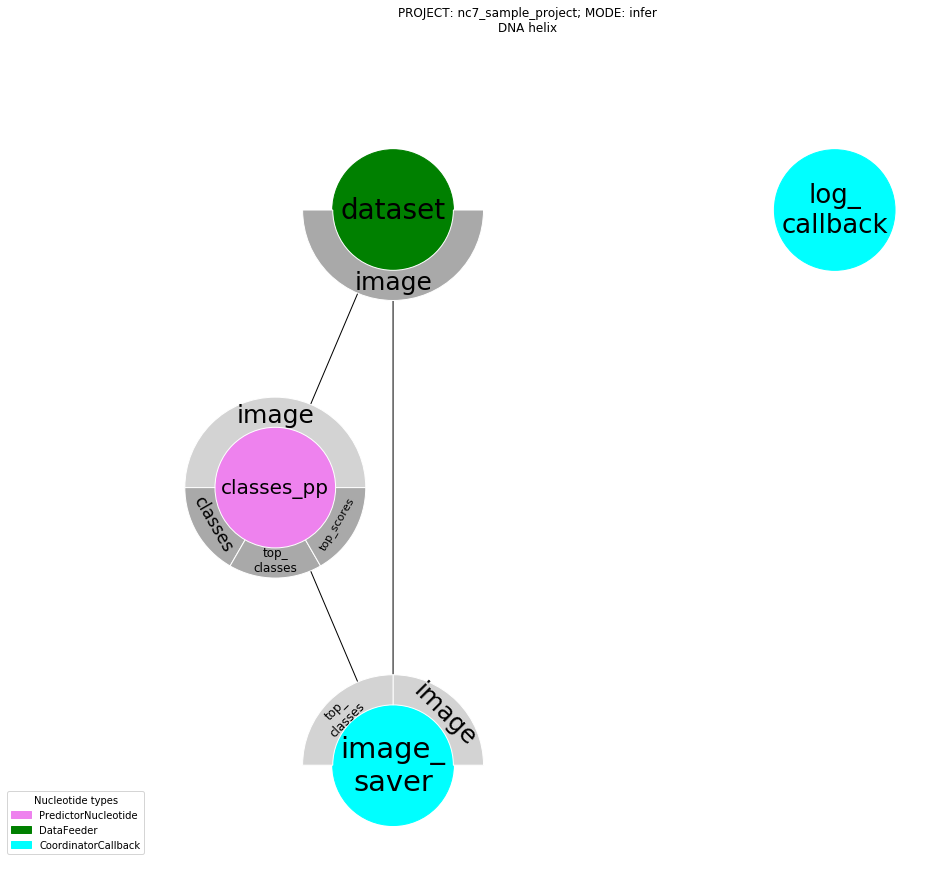

In [6]:
# uncomment following line if u want to have interactive plot ():
# %matplotlib agg
inferer.visualize_project_dna()

In [7]:
print_dir_content()

project_01_logs/nc7_sample_project/checkpoints: 
		['model.ckpt-300.index', 'model.ckpt-100.meta', 'model.ckpt-400.index', 'model.ckpt-200.meta', 'model.ckpt-500.meta', 'model.ckpt-500.data-00002-of-00003', 'model.ckpt-300.meta', 'model.ckpt-300.data-00000-of-00003', 'events.out.tfevents.1558359148.Vorobiov-UBUNTU', 'checkpoint', 'graph.pbtxt', 'model.ckpt-300.data-00001-of-00003', 'model.ckpt-500.data-00001-of-00003', 'model.ckpt-100.data-00000-of-00003', 'model.ckpt-200.index', 'model.ckpt-200.data-00002-of-00003', 'model.ckpt-100.index', 'model.ckpt-100.data-00002-of-00003', 'model.ckpt-500.data-00000-of-00003', 'model.ckpt-100.data-00001-of-00003', 'model.ckpt-400.data-00001-of-00003', 'model.ckpt-200.data-00001-of-00003', 'model.ckpt-500.index', 'model.ckpt-400.data-00000-of-00003', 'model.ckpt-200.data-00000-of-00003', 'model.ckpt-400.data-00002-of-00003', 'graph_inference.meta', 'input_output_names.json', 'model.ckpt-300.data-00002-of-00003', 'model.ckpt-400.meta']
project_01_lo

So, we have new folders:

* inference - everything related to the inference
    * configs - main configs to start inference (is empty, since we do not use them)
    * run-1 - every time you start the inference on the project, run number will be incremented
        * artifacts - artifacts of the inference, e.g. configs used
        * resuts - callbacks write here
        
Let's run the inference and wee what happens :)

In [8]:
inferer.run()

iter 00001 | time_exec 1.576


/home/alexv/anaconda3/lib/python3.5/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float32 to uint8
  .format(dtypeobj_in, dtypeobj_out))


iter 00002 | time_exec 0.003
iter 00003 | time_exec 0.003
iter 00004 | time_exec 0.003
iter 00005 | time_exec 0.003
iter 00006 | time_exec 0.003
iter 00007 | time_exec 0.003
iter 00008 | time_exec 0.003
iter 00009 | time_exec 0.003
iter 00010 | time_exec 0.003
iter 00011 | time_exec 0.003
iter 00012 | time_exec 0.003
iter 00013 | time_exec 0.003
iter 00014 | time_exec 0.003
iter 00015 | time_exec 0.003
iter 00016 | time_exec 0.003
iter 00017 | time_exec 0.003
iter 00018 | time_exec 0.003
iter 00019 | time_exec 0.003
iter 00020 | time_exec 0.003
iter 00021 | time_exec 0.003
iter 00022 | time_exec 0.003
iter 00023 | time_exec 0.003
iter 00024 | time_exec 0.003
iter 00025 | time_exec 0.003
iter 00026 | time_exec 0.003
iter 00027 | time_exec 0.003
iter 00028 | time_exec 0.003
iter 00029 | time_exec 0.003
iter 00030 | time_exec 0.003
iter 00031 | time_exec 0.003
iter 00032 | time_exec 0.003
iter 00033 | time_exec 0.003
iter 00034 | time_exec 0.003
iter 00035 | time_exec 0.003
iter 00036 | t

### 5. Results
First of all let's see how many files are inside of `infer_results/` folder and if all of x_test samples were precessed  and plot some of them

Number of generated files:  10000
Number of samples in x_test:  10000
First 10 file names:
['image_097_059_predicted_truck-cat.png',
 'image_057_082_predicted_bird-dog.png',
 'image_057_095_predicted_dog-cat.png',
 'image_085_018_predicted_automobile-truck.png',
 'image_017_007_predicted_frog-ship.png',
 'image_081_075_predicted_horse-cat.png',
 'image_031_007_predicted_horse-bird.png',
 'image_100_085_predicted_deer-bird.png',
 'image_066_037_predicted_automobile-horse.png']

and their plots


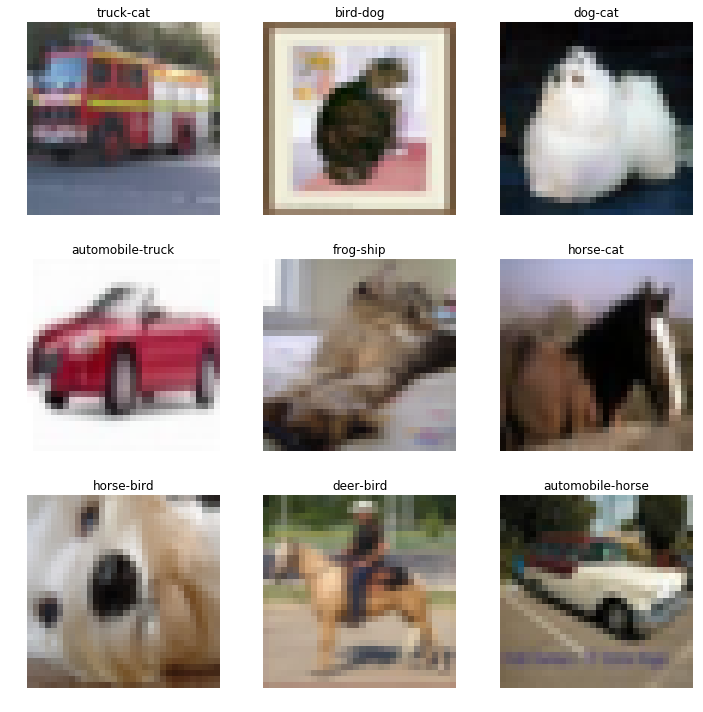

In [9]:
generated_predictions = os.listdir(inferer.project_dirs.callbacks)
print("Number of generated files: ", len(generated_predictions))
print("Number of samples in x_test: ", len(x_test))
print('First 10 file names:')
pprint.pprint(generated_predictions[:9])
print()
print('and their plots')

import matplotlib.pyplot as plt

f, axs = plt.subplots(3, 3, figsize=(10, 10))
for i, ax in enumerate(axs.flatten()):
    image = skimage.io.imread(os.path.join(inferer.project_dirs.callbacks, generated_predictions[i]))
    ax.imshow(image)
    ax.axis('off')
    label = os.path.splitext(generated_predictions[i])[0].split('_')[-1]
    ax.set_title(label)
f.tight_layout()

### Summary

I discribed how to infer nucleus7 model.

There is also a CLI interface (bin/nc7-infer), where you need to define only the configs as jsons and some paths. This method is **preferred**, as it is more cosine and you do not need to create multiple .py files, only json configurations.